In [1]:
%pip install -e ..
%load_ext autoreload
%autoreload 2

Obtaining file:///C:/Users/USER/Desktop/projects/Credit%20Score%20Modelling
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for credit-score-modelling (pyproject.toml): started
  Building editable for credit-score-modelling (pyproject.toml): finished with status 'done'
  Created wheel for credit-score-modelling: filename=credit_score_modelling-0.1.0-0.editable-py3-none-any.whl size=2389 sha256=75cdec9d7c6c5ae53cc431aba6caae255a6b3b2290f91353438f74649727d2a5
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-whee


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from pathlib import Path
import joblib, pickle

from credit_score.features.load_data  import load_split
from credit_score.features.cleaning   import fit_cleaning_metadata, clean_and_prepare
from credit_score.features.pipeline   import make_preprocessor

In [3]:
df_raw_val  = load_split("val")
df_raw_train = load_split("train")

meta     = fit_cleaning_metadata(df_raw_train)
df_train = clean_and_prepare(df_raw_train, meta)
df_val = clean_and_prepare(df_raw_val, meta)



[cleaning] Removed 5 fee outliers
[cleaning] Removed 2 fee outliers


In [4]:

X_train, y_train = df_train.drop("default", axis=1), df_train["default"]
X_val  , y_val   = df_val.drop("default", axis=1)  , df_val["default"]

In [5]:
preproc = make_preprocessor()
X_train_pp = preproc.fit_transform(X_train, y_train)   
X_val_pp   = preproc.transform(X_val)                  

In [6]:
from sklearn.linear_model import LogisticRegression
base_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
base_clf.fit(X_train_pp, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [9]:
from sklearn.metrics import roc_auc_score, classification_report
print("VAL AUC:", roc_auc_score(y_val, base_clf.predict_proba(X_val_pp)[:, 1]).round(4))
y_pred_base_clf = base_clf.predict(X_val_pp)
print(classification_report(y_pred=y_pred_base_clf, y_true=y_val))

VAL AUC: 0.9841
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      9123
        True       0.86      0.72      0.78       875

    accuracy                           0.97      9998
   macro avg       0.92      0.85      0.88      9998
weighted avg       0.96      0.97      0.96      9998



In [8]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

param_grid = {
    "n_estimators": randint(200, 600),
    "max_depth"   : randint(3, 12),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf" : randint(1, 10),
    "max_features": uniform(0.2, 0.8)   
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator  = RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions = param_grid,
    n_iter     = 40,
    scoring    = "roc_auc",
    cv         = cv,
    n_jobs     = -1,
    verbose    = 1,
)

search.fit(X_train_pp, y_train)
print("BEST CV AUC :", search.best_score_.round(4))

best_clf = search.best_estimator_
print("VAL AUC W/ BEST:", roc_auc_score(
      y_val, best_clf.predict_proba(X_val_pp)[:,1]).round(4))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
BEST CV AUC : 0.9856
VAL AUC W/ BEST: 0.9882


In [11]:
from sklearn.metrics import recall_score

param_grid = {
    "n_estimators": randint(200, 600),
    "max_depth"   : randint(3, 12),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf" : randint(1, 10),
    "max_features": uniform(0.2, 0.8)   
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator  = RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions = param_grid,
    n_iter     = 40,
    scoring    = "recall",
    cv         = cv,
    n_jobs     = -1,
    verbose    = 1,
)

search.fit(X_train_pp, y_train)
print("BEST recall train:", search.best_score_.round(4))

best_clf = search.best_estimator_
y_val_pred = best_clf.predict(X_val_pp)
print("VAL best recall:", recall_score(
      y_val, y_val_pred).round(4))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
BEST recall train: 0.7384
VAL best recall: 0.7509


### Attempt using undersampling

In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
y_val.value_counts(), y_train.value_counts()

(default
 False    9123
 True      875
 Name: count, dtype: int64,
 default
 False    31987
 True      3008
 Name: count, dtype: int64)

In [15]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_pp, y_train)

print(y_train_rus.value_counts())

default
False    3008
True     3008
Name: count, dtype: int64


In [17]:
clf_rus = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_rus.fit(X_train_rus, y_train_rus)

y_pred_val_rus = clf_rus.predict(X_val_pp)

print(classification_report(y_true=y_val, y_pred=y_pred_val_rus))

              precision    recall  f1-score   support

       False       1.00      0.91      0.95      9123
        True       0.52      0.96      0.67       875

    accuracy                           0.92      9998
   macro avg       0.76      0.94      0.81      9998
weighted avg       0.95      0.92      0.93      9998



### Oversampling using SMOTETomek

In [18]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_pp, y_train)
y_train_smt.value_counts()

default
False    31776
True     31776
Name: count, dtype: int64

In [19]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train_smt, y_train_smt)

y_pred_val_tomek = clf.predict(X_val_pp)

print(classification_report(y_true=y_val, y_pred=y_pred_val_tomek))

              precision    recall  f1-score   support

       False       0.99      0.93      0.96      9123
        True       0.55      0.95      0.70       875

    accuracy                           0.93      9998
   macro avg       0.77      0.94      0.83      9998
weighted avg       0.96      0.93      0.94      9998



### OPTUNA

In [21]:
import optuna
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np


In [22]:
def objective(trial):
    params = {
       "C" : trial.suggest_float("C", 1e-4, 1e4, log=True),
       "solver" : trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga", "newton-cg"]),
       "tol" : trial.suggest_float('tol', 1e-6, 1e-1, log=True),
       "class_weight" : trial.suggest_categorical("class_weight", [None, 'balanced']) 
    }
    
    model = LogisticRegression(**params, max_iter=10000)
    
    f1_scorer = make_scorer(f1_score, average="macro")
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_logistic = optuna.create_study(direction="maximize")
study_logistic.optimize(objective, n_trials=20)
    

[I 2025-06-06 11:56:05,228] A new study created in memory with name: no-name-87a0bdcf-c294-4931-a6ad-598ccbdf2b93
[I 2025-06-06 11:56:07,938] Trial 0 finished with value: 0.9470183517661851 and parameters: {'C': 107.02131227247902, 'solver': 'liblinear', 'tol': 0.0191340449958674, 'class_weight': None}. Best is trial 0 with value: 0.9470183517661851.
[I 2025-06-06 11:56:09,157] Trial 1 finished with value: 0.940571534499072 and parameters: {'C': 0.07695466213865378, 'solver': 'newton-cg', 'tol': 0.0012334763515034518, 'class_weight': None}. Best is trial 0 with value: 0.9470183517661851.
[I 2025-06-06 11:56:10,479] Trial 2 finished with value: 0.9140735829888526 and parameters: {'C': 0.0021157354260279444, 'solver': 'saga', 'tol': 4.1110789004393935e-05, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9470183517661851.
[I 2025-06-06 11:56:11,704] Trial 3 finished with value: 0.9158727624386658 and parameters: {'C': 0.0029139013233870957, 'solver': 'saga', 'tol': 0.0645721820

In [25]:
print("Best trial:")
trial = study_logistic.best_trial
print(f"F1 score: {trial.value}")
print("Params :")
for key, value in trial.params.items():
    print(" {}:{}".format(key, value))
    
best_model_logistic = LogisticRegression(**study_logistic.best_params)
best_model_logistic.fit(X_train_smt, y_train_smt)

y_pred_best_model_logistic = best_model_logistic.predict(X_val_pp)

print(classification_report(y_pred=y_pred_best_model_logistic, y_true=y_val))

Best trial:
F1 score: 0.9473052046802671
Params :
 C:6.175039124502925
 solver:newton-cg
 tol:1.0093428304629517e-06
 class_weight:balanced
              precision    recall  f1-score   support

       False       0.99      0.93      0.96      9123
        True       0.56      0.95      0.71       875

    accuracy                           0.93      9998
   macro avg       0.78      0.94      0.83      9998
weighted avg       0.96      0.93      0.94      9998



### Attempt Using:
####  XGBoost + SMOTE Tomek + Optuna tunning

In [27]:
from xgboost import XGBClassifier

In [28]:
def objective(trial):
    params = {
       'objective' : "binary:logistic",
       "eval_metric":"logloss",
       "verbosity" : 0,
       "booster" : "gbtree",
       "lambda" : trial.suggest_float("lambda", 1e-3,10.0,log=True),
       "alpha" : trial.suggest_float("alpha", 1e-3, 10.0, log=True),
       "subsample" : trial.suggest_float("subsample", 0.4, 1.0),
       "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.4,1.0),
       "max_depth" : trial.suggest_int("max_depth", 3,10),
       "eta" : trial.suggest_float( "eta", 0.01, 0.3),
       "gamma" : trial.suggest_float("gamma", 0, 10),
       "scale_pos_weight" : trial.suggest_float('scale_pos_weight', 1,10),
       "min_child_weight" : trial.suggest_int("min_child_weight", 1, 10),
       "max_delta_step" : trial.suggest_int("max_delta_step", 0,10)
    }
    
    model = XGBClassifier(**params)
    
    f1_scorer = make_scorer(f1_score, average="macro")
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective, n_trials=20)

[I 2025-06-06 12:16:06,706] A new study created in memory with name: no-name-a77b77f9-543e-4a6c-9693-83e2a512b557
[I 2025-06-06 12:16:09,181] Trial 0 finished with value: 0.9504732307323311 and parameters: {'lambda': 7.627873733753411, 'alpha': 5.77576124331479, 'subsample': 0.6717518645735279, 'colsample_bytree': 0.7395393368551765, 'max_depth': 7, 'eta': 0.08935047657818235, 'gamma': 1.2906320452363995, 'scale_pos_weight': 9.968542538714537, 'min_child_weight': 6, 'max_delta_step': 6}. Best is trial 0 with value: 0.9504732307323311.
[I 2025-06-06 12:16:10,919] Trial 1 finished with value: 0.962126855670009 and parameters: {'lambda': 0.1387257256680524, 'alpha': 0.7104218660808562, 'subsample': 0.5323391155270842, 'colsample_bytree': 0.7545518465588279, 'max_depth': 6, 'eta': 0.2892796625761041, 'gamma': 8.0695511575258, 'scale_pos_weight': 4.855289589111971, 'min_child_weight': 5, 'max_delta_step': 4}. Best is trial 1 with value: 0.962126855670009.
[I 2025-06-06 12:16:12,786] Trial 2

In [31]:
print("Best trial:")
trial_xgb = study_xgb.best_trial
print(f"F1 score: {trial_xgb.value}")
print("Params :")
for key, value in trial_xgb.params.items():
    print(" {}:{}".format(key, value))
    
best_model_xgb = XGBClassifier(**study_xgb.best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

y_pred_best_model_xgb = best_model_xgb.predict(X_val_pp)

print(classification_report(y_pred=y_pred_best_model_xgb, y_true=y_val))

Best trial:
F1 score: 0.9728585507237689
Params :
 lambda:0.0023561861549924504
 alpha:0.01550360403468254
 subsample:0.5195743634460546
 colsample_bytree:0.8500531091283663
 max_depth:8
 eta:0.2597374058138913
 gamma:0.5829442352137526
 scale_pos_weight:5.986823382853187
 min_child_weight:1
 max_delta_step:1
              precision    recall  f1-score   support

       False       0.99      0.95      0.97      9123
        True       0.64      0.93      0.76       875

    accuracy                           0.95      9998
   macro avg       0.82      0.94      0.86      9998
weighted avg       0.96      0.95      0.95      9998



### Logistic Regression Roc Curve

In [32]:
print(classification_report(y_pred=y_pred_best_model_logistic, y_true=y_val))

              precision    recall  f1-score   support

       False       0.99      0.93      0.96      9123
        True       0.56      0.95      0.71       875

    accuracy                           0.93      9998
   macro avg       0.78      0.94      0.83      9998
weighted avg       0.96      0.93      0.94      9998



In [35]:
from sklearn.metrics import roc_curve

probabilities = best_model_logistic.predict_proba(X_val_pp)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, probabilities)
fpr[:10], tpr[:10], thresholds[:10]

(array([0.        , 0.        , 0.        , 0.00010961, 0.00010961,
        0.00021923, 0.00021923, 0.00032884, 0.00032884, 0.00043845]),
 array([0.        , 0.00114286, 0.14057143, 0.14057143, 0.21028571,
        0.21028571, 0.256     , 0.256     , 0.29257143, 0.29257143]),
 array([       inf, 1.        , 0.99959166, 0.99959158, 0.99893698,
        0.99889793, 0.99800296, 0.9979858 , 0.99731681, 0.99726906]))

In [36]:
from sklearn.metrics import auc

area = auc(fpr, tpr)
area

0.9842232348381642

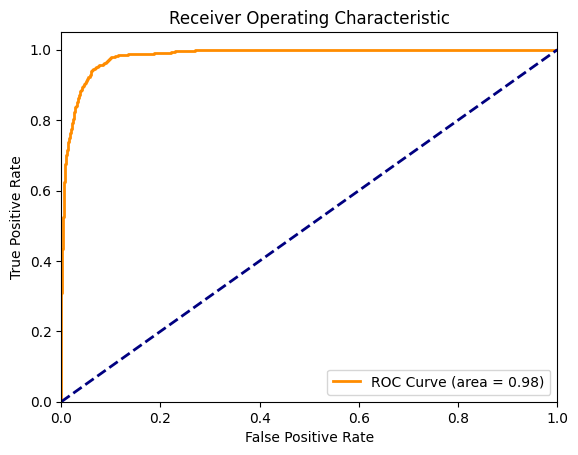

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label = "ROC Curve (area = %0.2f)" % area)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


### Model Evaluation: Rankorder & KS Statistic

In [43]:
import pandas as pd
probabilities = best_model_logistic.predict_proba(X_val_pp)[:,1]

df_eval = pd.DataFrame({
    "Default val Truth" : y_val,
    "Default Probability" : probabilities
})

df_eval.head()

,Default val Truth,Default Probability
0,False,5.995817e-04
1,False,3.070587e-07
2,False,3.426394e-05
3,False,1.589971e-05
4,False,3.567212e-03


In [44]:
df_eval["Decile"] = pd.qcut(df_eval["Default Probability"],10, labels=False, duplicates='drop')
df_eval.head()

,Default val Truth,Default Probability,Decile
0,False,5.995817e-04,4
1,False,3.070587e-07,0
2,False,3.426394e-05,3
3,False,1.589971e-05,2
4,False,3.567212e-03,5


In [46]:
df_grouped = df_eval.groupby("Decile").apply(lambda x: pd.Series({
    "Minimum Probabilities" : x["Default Probability"].min(),
    "Maximum Probability" : x["Default Probability"].max(),
    "Events" : x["Default val Truth"].sum(),
    "Non-events" : x["Default val Truth"].count() - x["Default val Truth"].sum(),
}))
df_grouped.reset_index(inplace=True)
df_grouped

C:\Users\USER\AppData\Local\Temp\ipykernel_528\4031255832.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df_eval.groupby("Decile").apply(lambda x: pd.Series({


,Decile,Minimum Probabilities,Maximum Probability,Events,Non-events
0,0,1.016750e-09,6.195486e-07,0.0,1000.0
1,1,6.207591e-07,4.797298e-06,0.0,1000.0
2,2,4.812948e-06,2.523674e-05,0.0,1000.0
3,3,2.534279e-05,1.303672e-04,0.0,999.0
4,4,1.306397e-04,7.077300e-04,0.0,1000.0
5,5,7.080165e-04,4.053620e-03,0.0,1000.0
6,6,4.060111e-03,2.764468e-02,3.0,996.0
7,7,2.764944e-02,2.204786e-01,9.0,991.0
8,8,2.207543e-01,8.318809e-01,130.0,870.0
9,9,8.333386e-01,1.000000e+00,733.0,267.0


In [48]:
df_grouped["Event Rate"] = df_grouped["Events"]*100 / (df_grouped["Events"]+df_grouped["Non-events"])
df_grouped["Non-event Rate"] = df_grouped["Non-events"]*100 / (df_grouped["Events"]+df_grouped["Non-events"])
df_grouped = df_grouped.sort_values(by="Decile", ascending=False).reset_index(drop=True)
df_grouped

,Decile,Minimum Probabilities,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,8.333386e-01,1.000000e+00,733.0,267.0,73.3000,26.7000
1,8,2.207543e-01,8.318809e-01,130.0,870.0,13.0000,87.0000
2,7,2.764944e-02,2.204786e-01,9.0,991.0,0.9000,99.1000
3,6,4.060111e-03,2.764468e-02,3.0,996.0,0.3003,99.6997
4,5,7.080165e-04,4.053620e-03,0.0,1000.0,0.0000,100.0000
5,4,1.306397e-04,7.077300e-04,0.0,1000.0,0.0000,100.0000
6,3,2.534279e-05,1.303672e-04,0.0,999.0,0.0000,100.0000
7,2,4.812948e-06,2.523674e-05,0.0,1000.0,0.0000,100.0000
8,1,6.207591e-07,4.797298e-06,0.0,1000.0,0.0000,100.0000
9,0,1.016750e-09,6.195486e-07,0.0,1000.0,0.0000,100.0000


In [49]:
df_grouped["Cum Events"] = df_grouped["Events"].cumsum()
df_grouped["Cum Non-events"] = df_grouped["Non-events"].cumsum()
df_grouped["Cum Event Rate"] = df_grouped["Cum Events"]*100 / df_grouped["Events"].sum()
df_grouped["Cum Non-event Rate"] = df_grouped["Cum Non-events"]*100 / df_grouped["Non-events"].sum()
df_grouped

,Decile,Minimum Probabilities,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,8.333386e-01,1.000000e+00,733.0,267.0,73.3000,26.7000,733.0,267.0,83.771429,2.926669
1,8,2.207543e-01,8.318809e-01,130.0,870.0,13.0000,87.0000,863.0,1137.0,98.628571,12.463006
2,7,2.764944e-02,2.204786e-01,9.0,991.0,0.9000,99.1000,872.0,2128.0,99.657143,23.325660
3,6,4.060111e-03,2.764468e-02,3.0,996.0,0.3003,99.6997,875.0,3124.0,100.000000,34.243122
4,5,7.080165e-04,4.053620e-03,0.0,1000.0,0.0000,100.0000,875.0,4124.0,100.000000,45.204428
5,4,1.306397e-04,7.077300e-04,0.0,1000.0,0.0000,100.0000,875.0,5124.0,100.000000,56.165735
6,3,2.534279e-05,1.303672e-04,0.0,999.0,0.0000,100.0000,875.0,6123.0,100.000000,67.116080
7,2,4.812948e-06,2.523674e-05,0.0,1000.0,0.0000,100.0000,875.0,7123.0,100.000000,78.077387
8,1,6.207591e-07,4.797298e-06,0.0,1000.0,0.0000,100.0000,875.0,8123.0,100.000000,89.038693
9,0,1.016750e-09,6.195486e-07,0.0,1000.0,0.0000,100.0000,875.0,9123.0,100.000000,100.000000


In [50]:
df_grouped["KS"] = abs(df_grouped["Cum Event Rate"] - df_grouped["Cum Non-event Rate"])
df_grouped

,Decile,Minimum Probabilities,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,8.333386e-01,1.000000e+00,733.0,267.0,73.3000,26.7000,733.0,267.0,83.771429,2.926669,80.844760
1,8,2.207543e-01,8.318809e-01,130.0,870.0,13.0000,87.0000,863.0,1137.0,98.628571,12.463006,86.165566
2,7,2.764944e-02,2.204786e-01,9.0,991.0,0.9000,99.1000,872.0,2128.0,99.657143,23.325660,76.331482
3,6,4.060111e-03,2.764468e-02,3.0,996.0,0.3003,99.6997,875.0,3124.0,100.000000,34.243122,65.756878
4,5,7.080165e-04,4.053620e-03,0.0,1000.0,0.0000,100.0000,875.0,4124.0,100.000000,45.204428,54.795572
5,4,1.306397e-04,7.077300e-04,0.0,1000.0,0.0000,100.0000,875.0,5124.0,100.000000,56.165735,43.834265
6,3,2.534279e-05,1.303672e-04,0.0,999.0,0.0000,100.0000,875.0,6123.0,100.000000,67.116080,32.883920
7,2,4.812948e-06,2.523674e-05,0.0,1000.0,0.0000,100.0000,875.0,7123.0,100.000000,78.077387,21.922613
8,1,6.207591e-07,4.797298e-06,0.0,1000.0,0.0000,100.0000,875.0,8123.0,100.000000,89.038693,10.961307
9,0,1.016750e-09,6.195486e-07,0.0,1000.0,0.0000,100.0000,875.0,9123.0,100.000000,100.000000,0.000000


In [57]:
gini_coefficient = 2 * area - 1

print("AUC :", area)
print("Gini Coefficient: ", gini_coefficient)

AUC : 0.9842232348381642
Gini Coefficient:  0.9684464696763284
